# Identify cells' localization related Ligand-receptor pairs

> (Estimated time: ~50 min with single GPU)

We shows how to identity cell localization related ligand-receptor pairs via `decipher`'s disentangled embeddings.

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from decipher import DECIPHER, CFG

In [ ]:
# We modify the default configuration to set k=10 for spatial graph construction
CFG.omics.spatial_graph.k = 10

## Step 1: Check data

We use a Lymph Node (LN) dataset captured by 10x Xenium 5k panel, which covers most of important ligan-receptor pairs. You can download the data from [Google Drive](https://drive.google.com/file/d/1rXHqjyz8EUpoWNvbs2BO4ZzCAMqTDCJO/view?usp=sharing).

In [2]:
adata = sc.read_h5ad("./lymph_node_mini.h5ad")

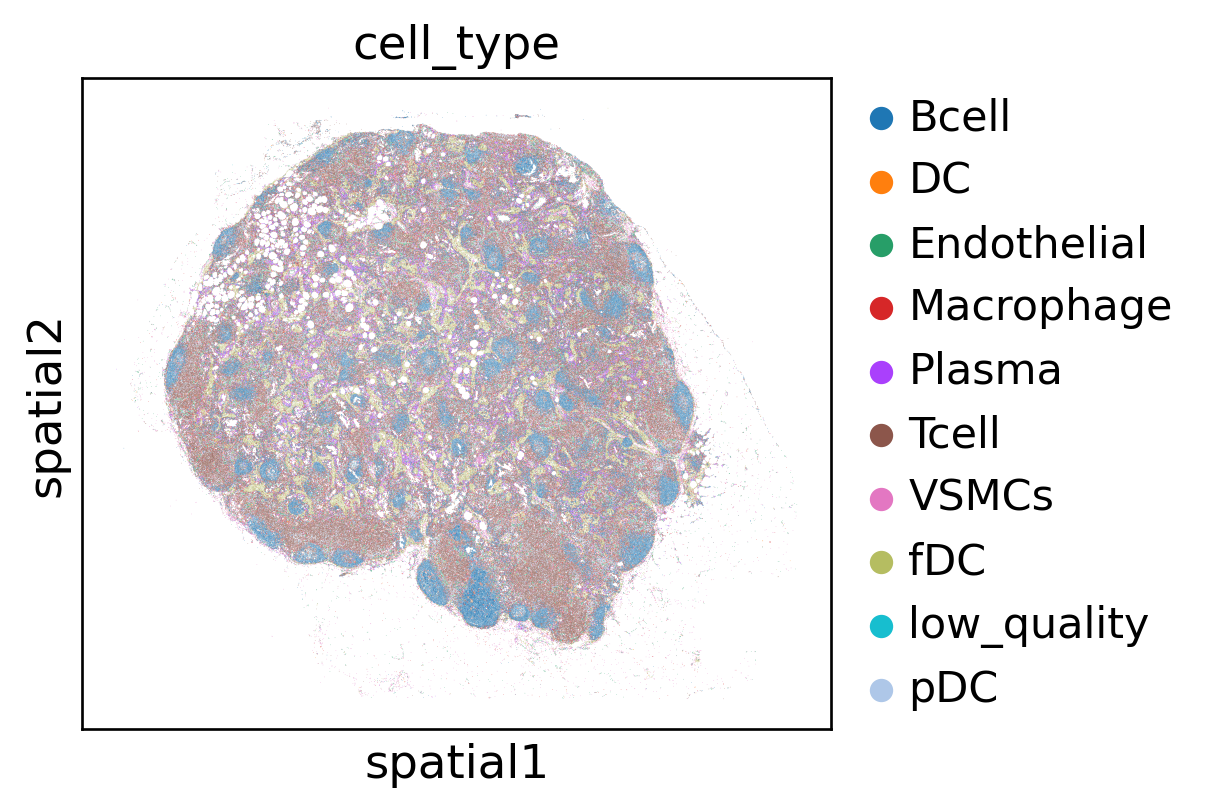

In [22]:
sc.pl.spatial(adata, color="cell_type", spot_size=6)

## Step 2: Run DECIPHER

In [ ]:
model = DECIPHER(work_dir="./decipher_find_lr", overwrite=True)
model.register_data(adata, cell_type="cell_type")
model.fit_omics()

2024-11-03 22:04:07.371 | SUCCESS  | decipher.utils:global_seed:347 - Global seed set to 0.


2024-11-03 22:04:07.475 | DEBUG    | decipher.data.process:omics_data_process:68 - adata 0 has 708983 cells, 4624 genes.
2024-11-03 22:04:07.482 | INFO     | decipher.data.process:omics_data_process:86 - Input: 1 slice(s) with 708983 cells and 1 batches.
2024-11-03 22:04:07.483 | INFO     | decipher.data.process:_preprocess_adata:98 - Preprocessing 708983 cells.
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-11-03 22:06:29.603 | SUCCESS  | decipher.data.process:_preprocess_adata:148 - Preprocessing finished in 142.12 seconds.
2024-11-03 22:06:49.407 | SUCCESS  | decipher.graphic.build:build_graph:102 - Built knn graph with 708983 nodes and 7089830 edges, 10.00 edges/node.


## Step 3: Find localization related ligand-receptor pairs

Then we find localization related ligand-receptor pairs based on DECIPHER embeddings. First, we need load ligand-receptor pairs information from [CellChatDB](http://www.cellchat.org/cellchatdb/). You can download the file from [here](https://drive.google.com/file/d/1RaWoWZdnUdDGbjTSSqhFr5B9_rRz15Kk/view?usp=sharing).

In [24]:
adata = sc.read_h5ad("./lymph_node_mini.h5ad")  # need reload the data
lr = pd.read_csv('./cellchat.csv')

Then we focus on the localization related ligand-receptor pairs of **B cells**.

In [25]:
model.train_gene_select(
    adata,
    cell_type='cell_type',
    subsets=['Bcell'],
    lr_mode=True,
    lr_data=lr,
    lr_radius=20,
    user_cfg=dict(gae_epochs = 100, lr_base = 0.01),
    n_jobs = 1
)

2024-11-03 23:26:19.506 | DEBUG    | decipher.explain.gene.mixin:train_gene_select:89 - Gene select config: {'k': 30, 'lr_base': 0.01, 'l1_weight': 1.0, 'gae_epochs': 100, 'test_ratio': 0.3, 'gumbel_threshold': 0.5, 'num_neighbors': [-1], 'fit': {'device': 'auto', 'select_gpu': True, 'device_num': 1, 'fp16': True, 'patient': 100, 'log_every_n_steps': 1, 'gradient_clip_val': 0, 'check_val_every_n_epoch': 1, 'max_steps': 10000, 'epochs': 300}, 'loader': {'batch_size': 32, 'shuffle': True, 'num_workers': 8, 'drop_last': True, 'pin_memory': True}, 'select_gpu': False, 'center_dim': 128, 'nbr_dim': 32, 'work_dir': 'decipher_find_lr/explain'}
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
2024-11-03 23:26:21.335 | INFO     | decipher.explain.gene.mixin:train_gene_select:99 - Run in Ligand-Receptor mode
2024-11-03 23:26:32.313 | INFO  

## Step 4: Visualize the results

At last, we get the top localization related ligand-receptor pairs found by model. Due to the randomness of optimization, the ranking of LRs may slightly differ from the results in our paper.

In [26]:
gene_mask = np.load('./decipher_find_lr/explain/select_celltype_Bcell/gene_mask.npy')
lr_df = pd.read_csv('./decipher_find_lr/explain/lr.csv')

lr_df['counts'] = gene_mask.sum(0)
# sort by counts
lr_df = lr_df.sort_values('counts', ascending=False)
lr_df[['counts', 'interaction_name']].head(20)
lr_df['score'] = lr_df['counts'] / gene_mask.shape[0]

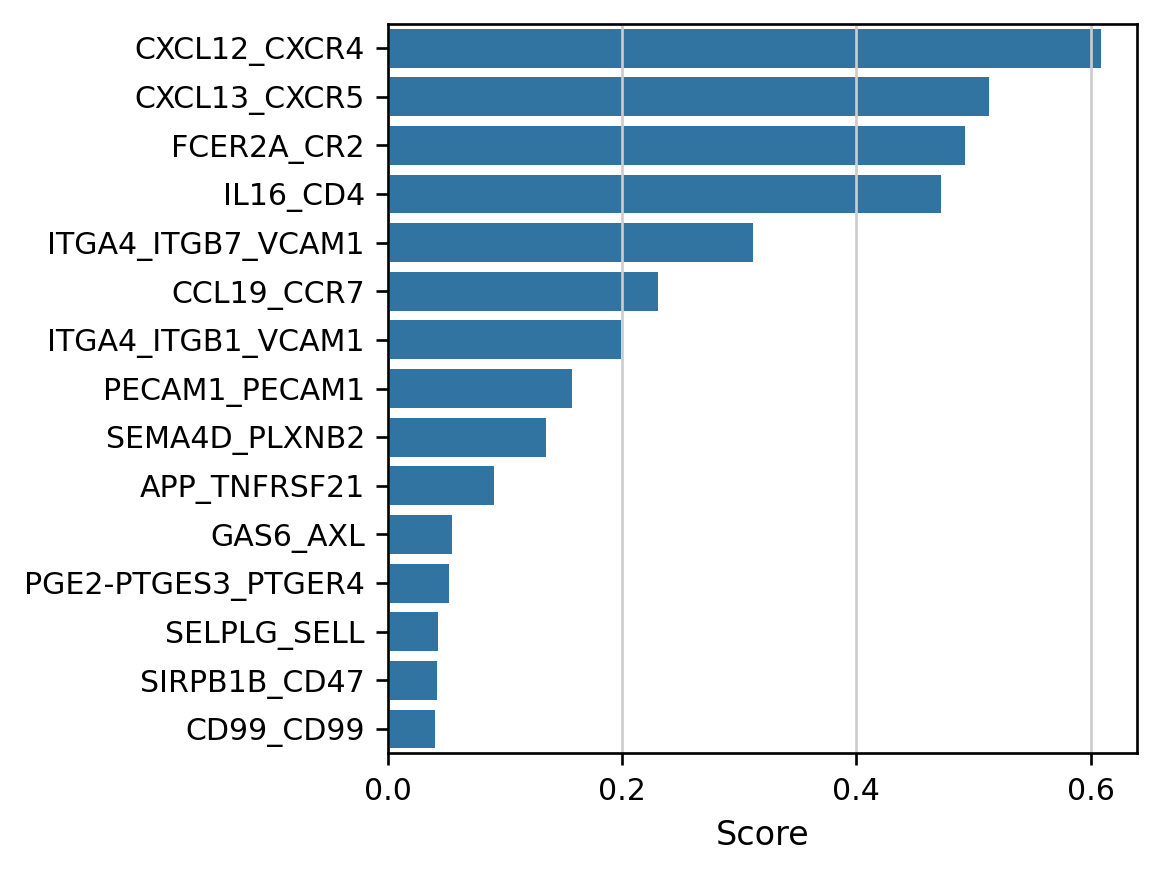

In [27]:
# Bar plot of top 15 ligand-receptor pairs
sns.barplot(x='score', y='interaction_name', data=lr_df.head(15))
plt.ylabel('')
_ = plt.yticks(fontsize=9)
_ = plt.xticks(fontsize=9)
_ = plt.xlabel('Score', fontsize=10)